##**Prepare data and environment(beta)**

In [1]:
%cd ..

/dellnas/home/tandongli/workdir/ECO-TR


##**Load inference engine**

In [2]:
import os,sys
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from dotmap import DotMap
from src.config.default import get_cfg_defaults
from src.utils.misc import lower_config
from src.models.ecotr_engines import *
from src.models.utils.utils import *

dict = DotMap(lower_config(get_cfg_defaults()))
dict.ecotr.engine.device='cuda:4'
fix_randomness(42)
engine=ECOTR_Engine(dict.ecotr)


##**Select image pairs**

In [40]:
torch.cuda.empty_cache()

pairs=[['./assets/34256848_2093205455.jpg','./assets/63163121_2253976476.jpg'], #taj
      ['./assets/recon_img_0.jpg','./assets/recon_img_1.jpg'], 
      ]

camera=[['./assets/calibration_000157.npy','./assets/calibration_000128.npy'],
        ['./assets/camera_0.npy','./assets/camera_1.npy']
       ]

pair_idx=1
img0=cv2.imread(pairs[pair_idx][0])[...,[2,1,0]]
img1=cv2.imread(pairs[pair_idx][1])[...,[2,1,0]]
camera_a = np.load(camera[pair_idx][0], allow_pickle=True).item()
camera_b = np.load(camera[pair_idx][1], allow_pickle=True).item() 


##**Func1. Coarse to fine Inference**

In [41]:
engine.MAX_KPTS_NUM=4000
engine.ASPECT_RATIOS=[1.0,1.5]

matches=engine.forward(img0,img1,cycle=True,level='fine')
# matches=engine.forward_2stage(img0,img1,cycle=False)
# refined_matches=engine.forward_refine(img0,img1,queries = matches[:,:2].reshape(-1,2),corrs = matches[:,2:4].reshape(-1,2))

mask=matches[:,-1]<1e-2
matches=matches[mask]

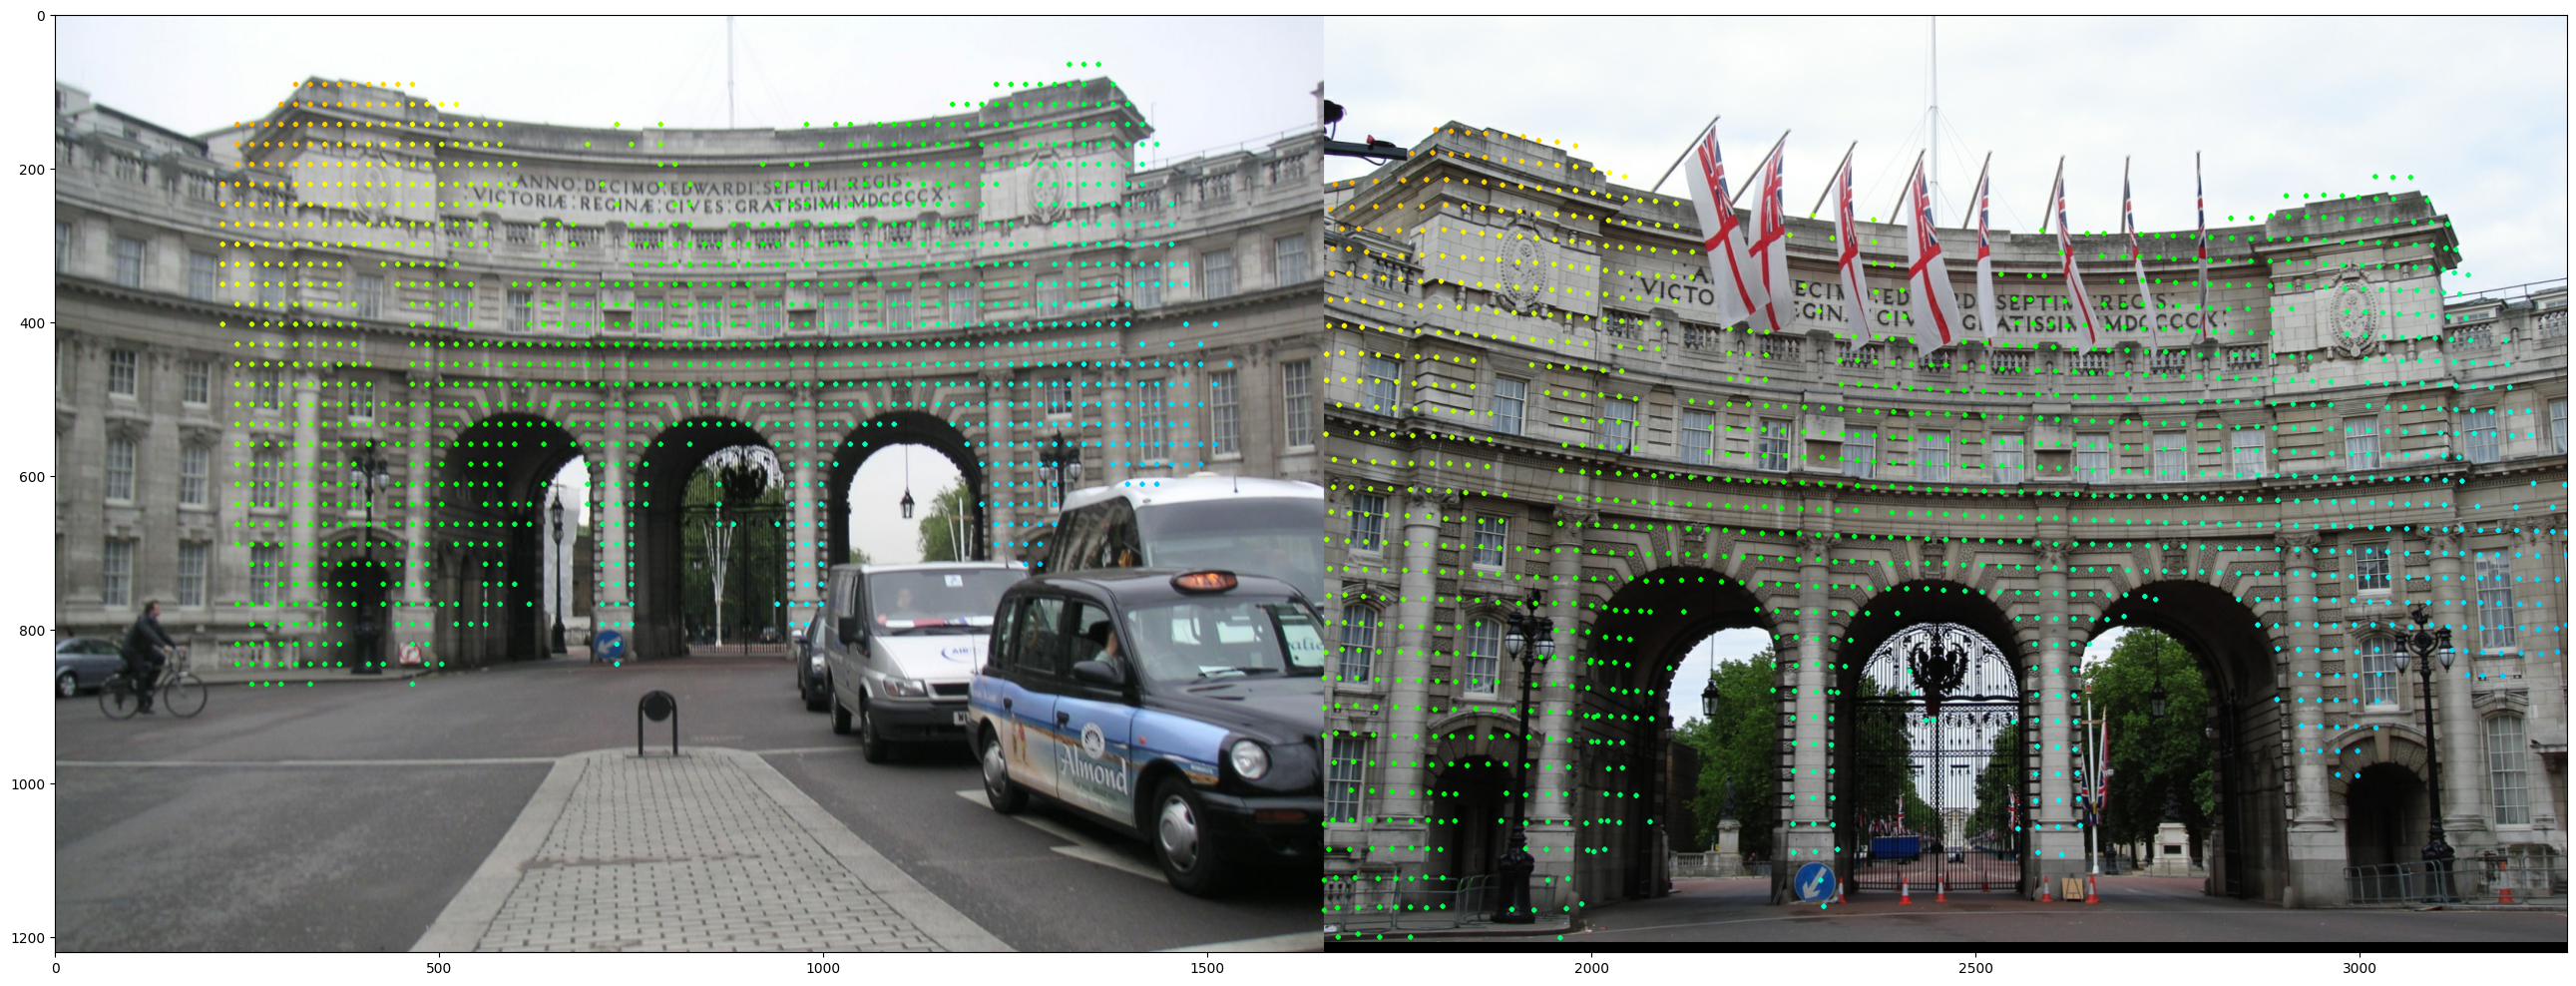

In [42]:
canvas = draw_matches(img0,img1,matches.copy(),'dot')
height,width = canvas.shape[:2]

dpi=100
figsize = width / float(dpi), height / float(dpi)
plt.figure(figsize=figsize)
plt.imshow(canvas)
plt.show()

##**Func3. Reconstruction func**

In [43]:
'''Copy from COTR(https://github.com/ubc-vision/COTR/blob/master/COTR/projector/pcd_projector.py)'''
'''
a point cloud projector based on np
'''
import numpy as np

def render_point_cloud_at_capture(point_cloud, capture, render_type='rgb', return_pcd=False):
    assert render_type in ['rgb', 'bw', 'depth']
    if render_type == 'rgb':
        assert point_cloud.shape[1] == 6
    else:
        point_cloud = point_cloud[:, :3]
        assert point_cloud.shape[1] == 3
    if render_type in ['bw', 'rgb']:
        keep_z = False
    else:
        keep_z = True

    pcd_2d = PointCloudProjector.pcd_3d_to_pcd_2d_np(point_cloud,
                            capture.intrinsic_mat,
                            capture.extrinsic_mat,
                            capture.size,
                            keep_z=True,
                            crop=True,
                            filter_neg=True,
                            norm_coord=False,
                            return_index=False)
    reproj = PointCloudProjector.pcd_2d_to_img_2d_np(pcd_2d,
                            capture.size,
                            has_z=True,
                            keep_z=keep_z)
    if return_pcd:
        return reproj, pcd_2d
    else:
        return reproj


def optical_flow_from_a_to_b(cap_a, cap_b):
    cap_a_intrinsic = cap_a.pinhole_cam.intrinsic_mat
    cap_a_img_size = cap_a.pinhole_cam.shape[:2]
    _h, _w = cap_b.pinhole_cam.shape[:2]
    x, y = np.meshgrid(
        np.linspace(0, _w - 1, num=_w),
        np.linspace(0, _h - 1, num=_h),
    )
    coord_map = np.concatenate([np.expand_dims(x, 2), np.expand_dims(y, 2)], axis=2)
    pcd_from_cap_b = cap_b.get_point_cloud_world_from_depth(coord_map)
    # pcd_from_cap_b = cap_b.point_cloud_world_w_feat(['pos', 'coord'])
    optical_flow = PointCloudProjector.pcd_2d_to_img_2d_np(PointCloudProjector.pcd_3d_to_pcd_2d_np(pcd_from_cap_b, cap_a_intrinsic, cap_a.cam_pose.world_to_camera[0:3, :], cap_a_img_size, keep_z=True, crop=True, filter_neg=True, norm_coord=False), cap_a_img_size, has_z=True, keep_z=False)
    return optical_flow


class PointCloudProjector():
    def __init__(self):
        pass

    @staticmethod
    def pcd_2d_to_pcd_3d_np(pcd, depth, intrinsic, motion=None, return_index=False):
        assert isinstance(pcd, np.ndarray), 'cannot process data type: {0}'.format(type(pcd))
        assert isinstance(intrinsic, np.ndarray), 'cannot process data type: {0}'.format(type(intrinsic))
        assert len(pcd.shape) == 2 and pcd.shape[1] >= 2
        assert len(depth.shape) == 2 and depth.shape[1] == 1
        assert intrinsic.shape == (3, 3)
        if motion is not None:
            assert isinstance(motion, np.ndarray), 'cannot process data type: {0}'.format(type(motion))
            assert motion.shape == (4, 4)
        # exec(debug_utils.embed_breakpoint())
        x, y, z = pcd[:, 0], pcd[:, 1], depth[:, 0]
        append_ones = np.ones_like(x)
        xyz = np.stack([x, y, append_ones], axis=1)  # shape: [num_points, 3]
        inv_intrinsic_mat = np.linalg.inv(intrinsic)
        xyz = np.matmul(inv_intrinsic_mat, xyz.T).T * z[..., None]
        valid_mask_1 = np.where(xyz[:, 2] > 0)
        xyz = xyz[valid_mask_1]

        if motion is not None:
            append_ones = np.ones_like(xyz[:, 0:1])
            xyzw = np.concatenate([xyz, append_ones], axis=1)
            xyzw = np.matmul(motion, xyzw.T).T
            valid_mask_2 = np.where(xyzw[:, 3] != 0)
            xyzw = xyzw[valid_mask_2]
            xyzw /= xyzw[:, 3:4]
            xyz = xyzw[:, 0:3]

        if pcd.shape[1] > 2:
            features = pcd[:, 2:]
            try:
                features = features[valid_mask_1][valid_mask_2]
            except UnboundLocalError:
                features = features[valid_mask_1]
            assert xyz.shape[0] == features.shape[0]
            xyz = np.concatenate([xyz, features], axis=1)
        if return_index:
            points_index = np.arange(pcd.shape[0])[valid_mask_1][valid_mask_2]
            return xyz, points_index
        return xyz

    @staticmethod
    def img_2d_to_pcd_3d_np(depth, intrinsic, img=None, motion=None):
        '''
        the function signature is not fully correct, because img is an optional
        if motion is None, the output pcd is in camera space
        if motion is camera_to_world, the out pcd is in world space.
        here the output is pure np array
        '''

        assert isinstance(depth, np.ndarray), 'cannot process data type: {0}'.format(type(depth))
        assert isinstance(intrinsic, np.ndarray), 'cannot process data type: {0}'.format(type(intrinsic))
        assert len(depth.shape) == 2
        assert intrinsic.shape == (3, 3)
        if img is not None:
            assert isinstance(img, np.ndarray), 'cannot process data type: {0}'.format(type(img))
            assert len(img.shape) == 3
            assert img.shape[:2] == depth.shape[:2], 'feature should have the same resolution as the depth'
        if motion is not None:
            assert isinstance(motion, np.ndarray), 'cannot process data type: {0}'.format(type(motion))
            assert motion.shape == (4, 4)

        pcd_image_space = PointCloudProjector.img_2d_to_pcd_2d_np(depth[..., None], norm_coord=False)
        valid_mask_1 = np.where(pcd_image_space[:, 2] > 0)
        pcd_image_space = pcd_image_space[valid_mask_1]
        xy = pcd_image_space[:, :2]
        z = pcd_image_space[:, 2:3]
        if img is not None:
            _c = img.shape[-1]
            feat = img.reshape(-1, _c)
            feat = feat[valid_mask_1]
            xy = np.concatenate([xy, feat], axis=1)
        pcd_3d = PointCloudProjector.pcd_2d_to_pcd_3d_np(xy, z, intrinsic, motion=motion)
        return pcd_3d

    @staticmethod
    def pcd_3d_to_pcd_2d_np(pcd, intrinsic, extrinsic, size, keep_z: bool, crop: bool = True, filter_neg: bool = True, norm_coord: bool = True, return_index: bool = False):
        assert isinstance(pcd, np.ndarray), 'cannot process data type: {0}'.format(type(pcd))
        assert isinstance(intrinsic, np.ndarray), 'cannot process data type: {0}'.format(type(intrinsic))
        assert isinstance(extrinsic, np.ndarray), 'cannot process data type: {0}'.format(type(extrinsic))
        assert len(pcd.shape) == 2 and pcd.shape[1] >= 3, 'seems the input pcd is not a valid 3d point cloud: {0}'.format(pcd.shape)

        xyzw = np.concatenate([pcd[:, 0:3], np.ones_like(pcd[:, 0:1])], axis=1)
        mvp_mat = np.matmul(intrinsic, extrinsic)
        camera_points = np.matmul(mvp_mat, xyzw.T).T
        if filter_neg:
            valid_mask_1 = camera_points[:, 2] > 0.0
        else:
            valid_mask_1 = np.ones_like(camera_points[:, 2], dtype=bool)
        camera_points = camera_points[valid_mask_1]
        image_points = camera_points / camera_points[:, 2:3]
        image_points = image_points[:, :2]
        if crop:
            valid_mask_2 = (image_points[:, 0] >= 0) * (image_points[:, 0] < size[1] - 1) * (image_points[:, 1] >= 0) * (image_points[:, 1] < size[0] - 1)
        else:
            valid_mask_2 = np.ones_like(image_points[:, 0], dtype=bool)
        if norm_coord:
            image_points = ((image_points / size[::-1]) * 2) - 1

        if keep_z:
            image_points = np.concatenate([image_points[valid_mask_2], camera_points[valid_mask_2][:, 2:3], pcd[valid_mask_1][:, 3:][valid_mask_2]], axis=1)
        else:
            image_points = np.concatenate([image_points[valid_mask_2], pcd[valid_mask_1][:, 3:][valid_mask_2]], axis=1)
        # if filter_neg and crop:
        #     exec(debug_utils.embed_breakpoint('pcd_3d_to_pcd_2d_np'))
        if return_index:
            points_index = np.arange(pcd.shape[0])[valid_mask_1][valid_mask_2]
            return image_points, points_index
        return image_points

    @staticmethod
    def pcd_2d_to_img_2d_np(pcd, size, has_z=False, keep_z=False):
        assert len(pcd.shape) == 2 and pcd.shape[-1] >= 2, 'seems the input pcd is not a valid point cloud: {0}'.format(pcd.shape)
        # assert 0, 'pass Z values in'
        if has_z:
            pcd = pcd[pcd[:, 2].argsort()[::-1]]
            if not keep_z:
                pcd = np.delete(pcd, [2], axis=1)
        index_list = np.round(pcd[:, 0:2]).astype(np.int32)
        index_list[:, 0] = np.clip(index_list[:, 0], 0, size[1] - 1)
        index_list[:, 1] = np.clip(index_list[:, 1], 0, size[0] - 1)
        _h, _w, _c = *size, pcd.shape[-1] - 2
        if _c == 0:
            canvas = np.zeros((_h, _w, 1))
            canvas[index_list[:, 1], index_list[:, 0]] = 1.0
        else:
            canvas = np.zeros((_h, _w, _c))
            canvas[index_list[:, 1], index_list[:, 0]] = pcd[:, 2:]

        return canvas

    @staticmethod
    def img_2d_to_pcd_2d_np(img, norm_coord=True):
        assert isinstance(img, np.ndarray), 'cannot process data type: {0}'.format(type(img))
        assert len(img.shape) == 3

        _h, _w, _c = img.shape
        if norm_coord:
            x, y = np.meshgrid(
                np.linspace(-1, 1, num=_w),
                np.linspace(-1, 1, num=_h),
            )
        else:
            x, y = np.meshgrid(
                np.linspace(0, _w - 1, num=_w),
                np.linspace(0, _h - 1, num=_h),
            )
        x, y = x.reshape(-1, 1), y.reshape(-1, 1)
        feat = img.reshape(-1, _c)
        pcd_2d = np.concatenate([x, y, feat], axis=1)
        return pcd_2d


def triangulate_rays_to_pcd(center_a, dir_a, center_b, dir_b):
    A = center_a
    a = dir_a / np.linalg.norm(dir_a, axis=1, keepdims=True)
    B = center_b
    b = dir_b / np.linalg.norm(dir_b, axis=1, keepdims=True)
    c = B - A
    D = A + a * ((-np.sum(a * b, axis=1) * np.sum(b * c, axis=1) + np.sum(a * c, axis=1) * np.sum(b * b, axis=1)) / (np.sum(a * a, axis=1) * np.sum(b * b, axis=1) - np.sum(a * b, axis=1) * np.sum(a * b, axis=1)))[..., None]
    return D


In [44]:
def toPLY(points, color, plyfile):
    """ Output graph structure to *.ply format. """
    num_pts = len(points)

    pts3D_matrix = points.astype(np.float32)
    color_matrix = color.astype(np.uint8)

    # output to file
    f = open(plyfile, "wb")
    f.write("ply\n".encode())
    f.write("format ascii 1.0\n".encode())
    f.write(("element vertex %d\n" % num_pts).encode())
    f.write("property float x\n".encode())
    f.write("property float y\n".encode())
    f.write("property float z\n".encode())
    f.write("property uchar blue\n".encode())
    f.write("property uchar green\n".encode())
    f.write("property uchar red\n".encode())
    f.write("end_header\n".encode())

    for i in range(num_pts):
        pt = (pts3D_matrix[i,0], pts3D_matrix[i,1], pts3D_matrix[i,2], 
              color_matrix[i,0], color_matrix[i,1], color_matrix[i,2])
        f.write(("%f %f %f %d %d %d\n" % pt).encode())
    f.close()

##**Func4. Reconstruction**

In [45]:
center_a = camera_a['cam_center']
center_b = camera_b['cam_center']

rays_a = PointCloudProjector.pcd_2d_to_pcd_3d_np(matches[:, :2], np.ones([matches.shape[0], 1]) * 2, camera_a['intrinsic'], motion=camera_a['c2w'])
rays_b = PointCloudProjector.pcd_2d_to_pcd_3d_np(matches[:, 2:4], np.ones([matches.shape[0], 1]) * 2, camera_b['intrinsic'], motion=camera_b['c2w'])

dir_a = rays_a - center_a
dir_b = rays_b - center_b
center_a = np.array([center_a] * matches.shape[0])
center_b = np.array([center_b] * matches.shape[0])
points = triangulate_rays_to_pcd(center_a, dir_a, center_b, dir_b)
colors = ((img0[tuple(np.floor(matches[:, :2]).astype(int)[:, ::-1].T)] / 255 + img1[tuple(np.floor(matches[:, 2:4]).astype(int)[:, ::-1].T)] / 255) / 2)*255
colors = np.array(colors).astype(np.uint8)[...,::-1]

toPLY(points,colors,'./recon.ply')